# digital narratives of COVID-19: frequency bar chart

In this notebook we demonstrate how to use *coveet*, a Python script that retrieves basic statistics (most frequent words, bigrams, trigrams, top users, hashtags) from our curated COVID-19 database about our collection. We visualize the results using bar charts to get a sense of top words/bigrams/trigrams/ec. over the span of a week in each geographic area. Please feel free to modify this notebook or, if you would like to preserve this version, make a copy of it by clicking "File" > "Make a Copy..."

To follow along, we recommend running the script portions piecemeal, in order.

__Author:__

* Jerry Bonnell, [j.bonnell@miami.edu](mailto:j.bonnell@miami.edu), University of Miami



## 0. Setting Up

Before we get started, let's set up the notebook by installing and importing libraries we need. The `requirements.txt` file specifies all the packages to install on your computer for this notebook. 

In [ ]:
!pip3 install -r requirements.txt  # may need to replace "pip3" with "conda"

In [1]:
import numpy as np
import pandas as pd
from coveet import count_ngrams, uniq_vocab_by_group
from collections import Counter
from pprint import pprint
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)
pd.options.mode.chained_assignment = None

## 1. Querying the database API + filtering stopwords

__NOTE__ Documentation for the coveet tool is available on the [project GitHub](https://github.com/dh-miami/narratives_covid19/tree/master/scripts/freq_analysis).

We first use coveet to query one week of tweets written in each geographic area. All of the geolocated tweets are written in Spanish, with the exception of Florida where both Spanish and English tweets are obtained. 

Furthermore, we assume that the user has prepared a list of stopwords in English and Spanish. In this example, one file contains stopwords for English and another for Spanish.

In [3]:
!python3 coveet.py query -g fl ar co ec es mx pe -l en es -d 2020-05-08 2020-05-14 -stopwords ../stopwords/stopwords_en.txt ../stopwords/stopwords_es.txt ../stopwords/stopwords_hashtags.txt

Namespace(date=[datetime.datetime(2020, 5, 8, 0, 0), datetime.datetime(2020, 5, 14, 0, 0)], func=<function handle_query at 0x112cc8830>, geo=['fl', 'ar', 'co', 'ec', 'es', 'mx', 'pe'], lang=['en', 'es'], stopwords=['../stopwords/stopwords_en.txt', '../stopwords/stopwords_es.txt', '../stopwords/stopwords_hashtags.txt'])
wrote df to dhcovid_2020-5-8_to_2020-5-14_en_es_ar_co_ec_es_fl_mx_pe.csv!


The coveet script just wrote the results to a CSV file called `dhcovid_2020-5-8_to_2020-5-14_en_es_ar_co_ec_es_fl_mx_pe.csv`. Let's load in this CSV using `pandas`.

In [2]:
df = pd.read_csv('dhcovid_2020-5-8_to_2020-5-14_en_es_ar_co_ec_es_fl_mx_pe.csv', index_col=0)

Let's have a look at what this dataframe looks like...

In [3]:
df

,date,lang,geo,text,hashtags
0,2020-05-08,es,pe,hijos alberto fujimori presentaron habeas corpus excarcelacion exmandatario riesgo contagio,NaN
1,2020-05-08,es,pe,nuevas medidas distanciamiento social circulacion dictadas gobierno,NaN
2,2020-05-08,es,pe,clinica dentro barbadillo da x mal servido si puede alguna forma ayudar pueblo peruano librarse karmas funestos deben aprovechar coyuntura q vaya mejores lares pais responsabilidad,NaN
3,2020-05-08,es,pe,sedes cochabamba revela posible fenomeno iceberg cuanto casos traves,NaN
4,2020-05-08,es,pe,anunciado debido estreno anime gotoubun hanayome :_emoji_not_identified_U222C_: retrasara enero,NaN
...,...,...,...,...,...
224732,2020-05-14,en,fl,breaking dr fauci proclaims 8 new vaccines ready fall,NaN
224733,2020-05-14,en,fl,sec filing dating back last week uber disclosed plans layoff 3700 employees figure amounts around 14 percent ride hailing giantrsquos total workforce document company states,NaN
224734,2020-05-14,en,fl,join ms focus teleconference designed help improve life ms expert speaker mitzi williams md topic care minorities join teleconference call 7207409380 preregister today,NaN
224735,2020-05-14,en,fl,emotional roi one key performance indicators video,NaN


Nice :-) Let's do some quick pre-processing of this dataframe in preparation for the visualization task. Namely, we are going to convert the date column to a `datetime` object since that makes working with dates easier. We will also split the dataframe into two by subsetting the df columns, one for the tweet text and another for the hashtags.

In [4]:
df['date'] = pd.to_datetime(df['date'])
df['text'] = df['text'].str.split()
df['hashtags'] = df['hashtags'].str.split()

## 2. Retrieving top n-grams or hashtags

Let's have a look at the top 10 results in each area. First, we define some variables.

In [5]:
top_n = 10  # top 10 words
n_gram = 1  # ask for word frequency (i.e. an n-gram where n=1)

Let's toggle a variable to determine whether we will retrieve n-grams or hashtags.

In [6]:
col_name = 'text'  # set to either 'text' or 'hashtags'

We'll subset the dataframe to contain only tweets or hashtags based on this toggle variable, and drop any cells with missing values (due to a tweet consisting of a body but with no hashtags, or vice versa).  

In [7]:
df = df.dropna(subset=[col_name])

We will create another dictionary where each key is a location-language pair, and the value is a list of the top occurrences under that setting. The code here invokes a function `count_ngrams()` from coveet to prepare the top n-gram and hashtag information. 

A brief note on how these n-grams are obtained: I treat the full tweet as context, rather than adjacent neighbors, in light of how short a "tweet" unit is. For instance, when obtaining bigrams, I consider the occurrence of two words together in a tweet as bigrams, regardless of whether they are adjacent. This could lead to possibly interesting findings, but we should discuss. 

In [8]:
# counts is of the form: location, language, actual tuples
# count_ngrams returns a (default) dictionary of word tuples (ngrams) 
# with its associated frequency; we then use Counter from python collections 
# to tell us the top n most popular ones 
counts = {(g, l): Counter(count_ngrams(t, n_gram, consecutive=False)).most_common(top_n)
          for (g, l), t in df.groupby(["geo", "lang"])[col_name]}

Let's have a look at what we just did.

In [9]:
pprint(counts)

{('ar', 'es'): [(('casos',), 1789),
                (('mas',), 1490),
                (('pandemia',), 920),
                (('si',), 860),
                (('coronavirus',), 823),
                (('nuevos',), 766),
                (('hoy',), 727),
                (('salud',), 629),
                (('argentina',), 622),
                (('pais',), 582)],
 ('co', 'es'): [(('casos',), 4577),
                (('mas',), 4569),
                (('salud',), 2648),
                (('pandemia',), 2370),
                (('colombia',), 2189),
                (('si',), 2122),
                (('hoy',), 2001),
                (('nuevos',), 1889),
                (('mayo',), 1867),
                (('coronavirus',), 1866)],
 ('ec', 'es'): [(('mas',), 1357),
                (('casos',), 1019),
                (('salud',), 923),
                (('ecuador',), 726),
                (('pandemia',), 722),
                (('si',), 653),
                (('contagio',), 603),
                (('mayo',

## 3. Visualization

Now we're ready to visualize! First we initialize some `matplotlib`  settings.

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 40, 40  # setting figure size
plt.rcParams.update({'font.size': 22})  # setting font size

We create a matrix of bar charts, one for each location-language pair. The order visualization can be reversed by toggling the `invert_yaxis()` function call in `plot_bar_matrix()`.

In [27]:
def plot_bar_matrix(counts, num_cols):
    """
    function for plotting a matrix of bar plots 
    
    counts: a dictionary mapping from a geo-lang pair identifier (generalizable to any identifier)
            to a list of (word, count) tuples containing the top word frequencies
    num_cols: desired number of columns to show in the grid
    str_func: function for "pretty printing" the title used in each of the bar charts  
    """
    # automatically determine the grid to use based on desired number of columns 
    num_rows = len(counts.keys()) // num_cols
    num_rows += 1 if num_rows * num_cols < len(counts.keys()) else 0
    fig, axes = plt.subplots(num_rows, num_cols)
    flattened = axes.flatten()
    for i, (id_pair, counts) in enumerate(counts.items()):
        labels = [" ".join(w) for w, _ in counts]
        y = [n for _, n in counts]
        cmap = plt.get_cmap('spring')
        colors = plt.get_cmap('spring')(np.linspace(0, 1, len(labels)))
        flattened[i].set_title(f"{' '.join([str(p) for p in id_pair])}")
        flattened[i].barh(y=range(0,10), width=y, color=colors, tick_label=labels)
        flattened[i].invert_yaxis()  # reverse the visualization order along the y-axis

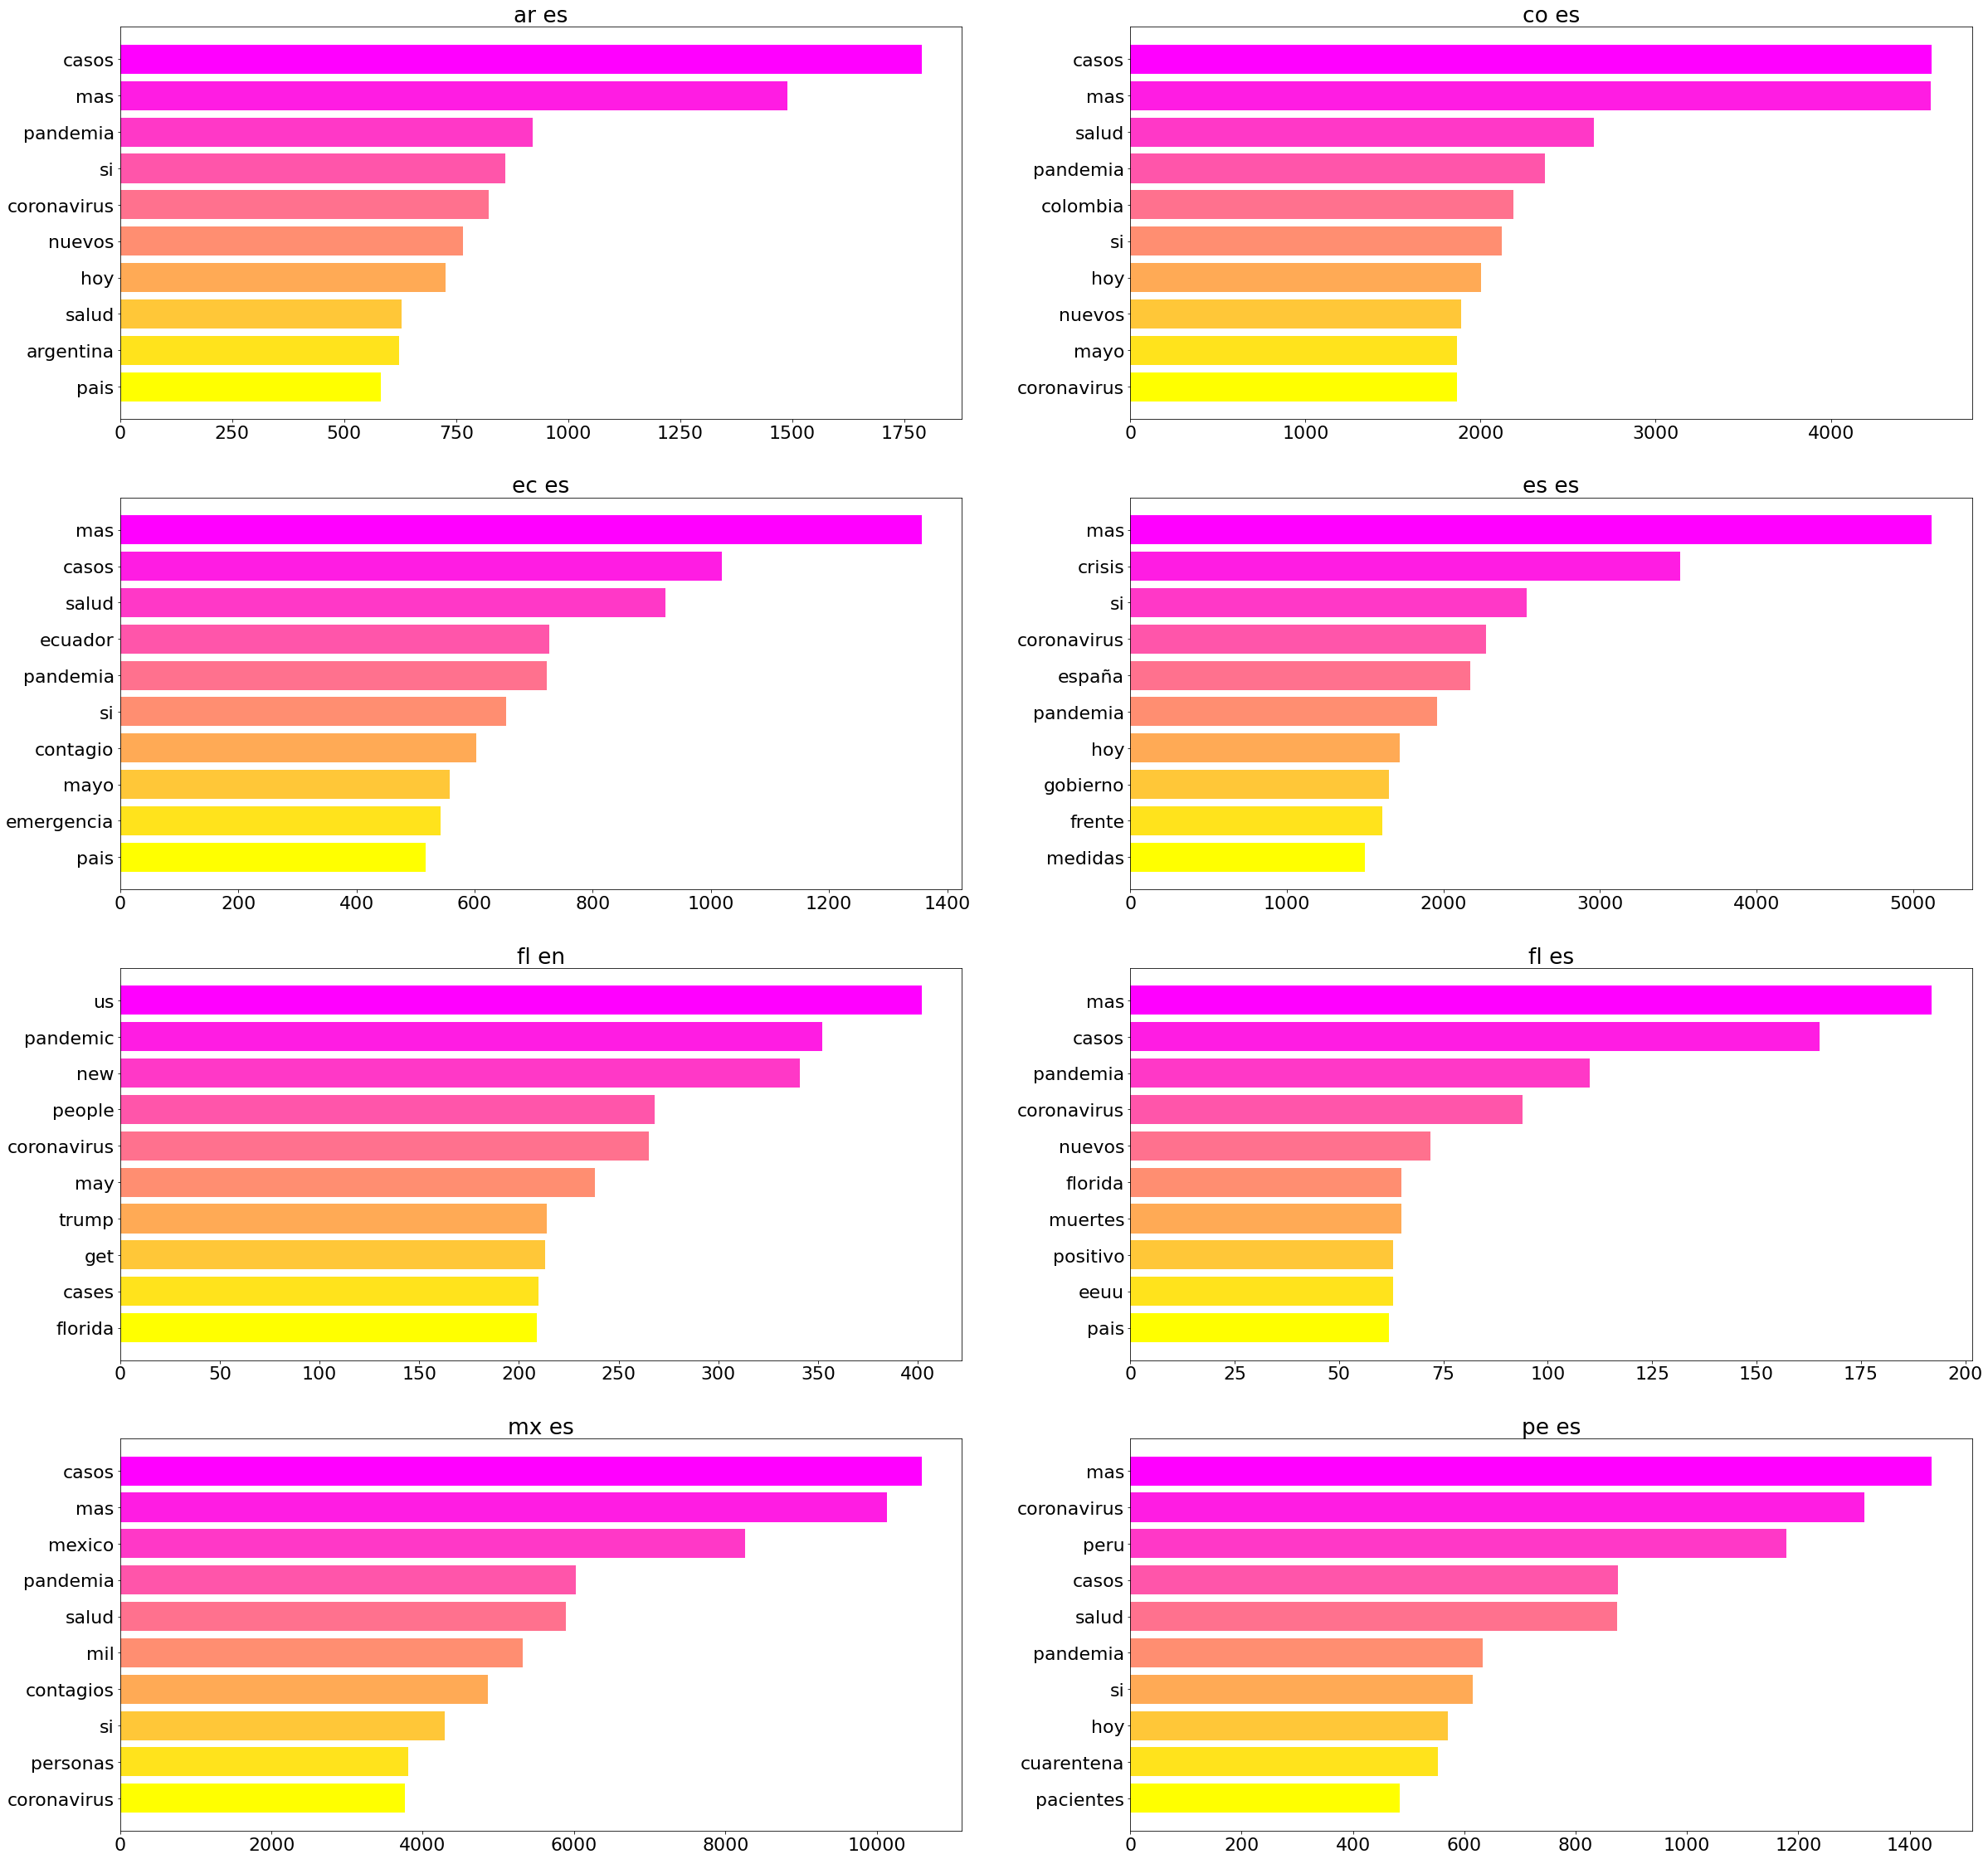

In [28]:
plot_bar_matrix(counts, num_cols = 2)

## 4. More advanced explorations 

In this final part of the notebook, I introduce two different analyses that can enable more advanced explorations of the tweet data: (1) concordance views, (2) unique words by location-language pair mode, and (3) unique words by date mode. We will still be making use of the tweet data we queried earlier in the notebook, available in `df`.  

### 4.1. Concordance views

I defer to the NLTK documentation for a definition: "a *concordance* view shows us every occurrence of a given word, together with some context." The context is usually defined by a window of some number of characters. Given the short and atomic nature of tweets, it would be fair to consider the full tweet as context for the concordance view. We would also like to display the associated date of that tweet.

The work needed to find concordances with its associated date is straightforward thanks to `pandas`. We will need to prepare a new query CSV, this time without applying any preprocessing steps (e.g., filtering stopwords) so we are better able to study the context. After this CSV has been created, we will load it in using `pandas`. 

In [13]:
!python3 coveet.py query -g fl ar co ec es mx pe -l en es -d 2020-05-08 2020-05-14

Namespace(date=[datetime.datetime(2020, 5, 8, 0, 0), datetime.datetime(2020, 5, 14, 0, 0)], func=<function handle_query at 0x11d09b830>, geo=['fl', 'ar', 'co', 'ec', 'es', 'mx', 'pe'], lang=['en', 'es'], stopwords=None)
wrote df to dhcovid_2020-5-8_to_2020-5-14_en_es_ar_co_ec_es_fl_mx_pe_no-stopwords.csv!


In [29]:
df_concord = pd.read_csv('dhcovid_2020-5-8_to_2020-5-14_en_es_ar_co_ec_es_fl_mx_pe_no-stopwords.csv', index_col=0)
df_concord = df_concord.dropna(subset=["text"])

Now that we have `df_concord`, the remaining work needed is to filter the rows to include only those that match the given word. This filter `filt` can be as simple as a single word (tweets where `nuevo` appears) or as advanced as logical expressions (tweets where `nuevo` and `america` appears). I show examples for both. 

In [31]:
filt = lambda text: 'nuevo' in text  # a single word
# filt = lambda text: 'nuevo' in text and 'america' in text      # a logical expression 
# filt = lambda text: 'trump' in text and not 'china' in text    # another one to try

In [32]:
df_concord = df_concord[df_concord.apply(lambda x: filt(x["text"]), axis=1)]

In [33]:
df_concord

,date,lang,geo,text,hashtags
29,2020-05-08,es,ec,el banco mundial anuncio el viernes que puso a disposicion inmediata del gobierno de bolivia 170 millones de dolares para fortalecer la capacidad de respuesta del sistema de salud ante la pandemia del nuevo coronavirus detalles,NaN
30,2020-05-08,es,ec,el banco mundial anuncio el viernes que puso a disposicion inmediata del gobierno de bolivia 170 millones de dolares para fortalecer la capacidad de respuesta del sistema de salud ante la pandemia del nuevo coronavirus detalles,NaN
48,2020-05-08,es,ec,españa registro 282 891 nuevos desempleados en abril ante impacto de la pandemia de covid19,NaN
126,2020-05-08,es,ec,segun reporte emitido hoy por el ministerio de salud publica la cifra de contagiados en el pais se redujo ayer registro 30298 casos confirmados y hoy registra 28818 el ministro zevallos explico se debe a la ejecucion del nuevo aplicativo para la difusion de cifras,#covid19
136,2020-05-08,es,ec,el ministerio de salud de reporto este viernes que el pais tiene 1391 nuevos casos de elevando la cifra total a 25972 infectados a su vez en las ultimas horas se registraron nueve fallecimientos por ascendiendo la cantidad de victimas a 294,#chile #coronavirus #covid19
...,...,...,...,...,...
219498,2020-05-14,es,es,el congreso de ee uu propone un nuevo plan de rescate tras la crisis economica generada por la covid19 :writing_hand:,#eeuu
219514,2020-05-14,es,es,ha registrado 157 nuevos casos del 25 nuevos casos de recuperacion y 10 muertes lo que eleva el numero total de casos de infeccion desde el comienzo de la epidemia a,#covid19
219559,2020-05-14,es,es,el bajo porcentaje de poblacion contagiada favorece la amenaza de un nuevo brote explosivo de covid19,NaN
219560,2020-05-14,es,es,america nuevo epicentro de la pandemia de covid19 al superar a europa en casos,NaN


It would be useful to write this dataframe to file so let's do that. 

In [66]:
df_concord.to_csv("concordance_view.csv")

### 4.2. Unique words by location-language pair mode

We may be interested in obtaining words that are *unique* to a location-language pair, i.e., for an input file that contains information about `mx-es`, `es-es`, and `fl-es`, words that occur *only* in `mx-es` and not in `es-es` and `fl-es`. 

We can invoke the function `uniq_vocab_by_group()` from *coveet* to retrieve a dictionary for a location-language pair's unique vocabulary, and filter `df` with that dictionary using `apply()` from `pandas`. Put less technically, each row of `df` will only contain words/hashtags that are unique to that location-language pair.

In [35]:
grouping = df.groupby(["geo", "lang"])["text"]
vocab_dic = uniq_vocab_by_group(grouping)  # unique vocab dictionary 
# recall that col_name is a toggle variable set earlier in the notebook ("text" or "hashtags")
df[col_name] = df.apply(lambda x : set(x[col_name]) & vocab_dic[(x['geo'], x['lang'])],
                        result_type='reduce', axis=1)  # filtering tweets by that dic

Let's visualize top frequencies!

In [36]:
counts = {k: Counter(count_ngrams(t, n_gram, consecutive=False)).most_common(top_n) for k, t in grouping}

In [37]:
pprint(counts)

{('ar', 'es'): [(('astori',), 67),
                (('bonaerense',), 36),
                (('amba',), 35),
                (('macri',), 35),
                (('conurbano',), 32),
                (('asse',), 25),
                (('porteñas',), 24),
                (('0420',), 22),
                (('quilmes',), 22),
                (('sinae',), 20)],
 ('co', 'es'): [(('boyaca',), 147),
                (('monteria',), 95),
                (('corabastos',), 64),
                (('tunja',), 62),
                (('cucuta',), 60),
                (('bucaramanga',), 58),
                (('panameños',), 45),
                (('veraguas',), 41),
                (('manizales',), 41),
                (('panameña',), 41)],
 ('ec', 'es'): [(('ñuka',), 8),
                (('09d01',), 8),
                (('inalterable',), 8),
                (('may2021',), 8),
                (('577',), 8),
                (('ambato',), 8),
                (('recuerdelo',), 8),
                (('weir',), 7),
 

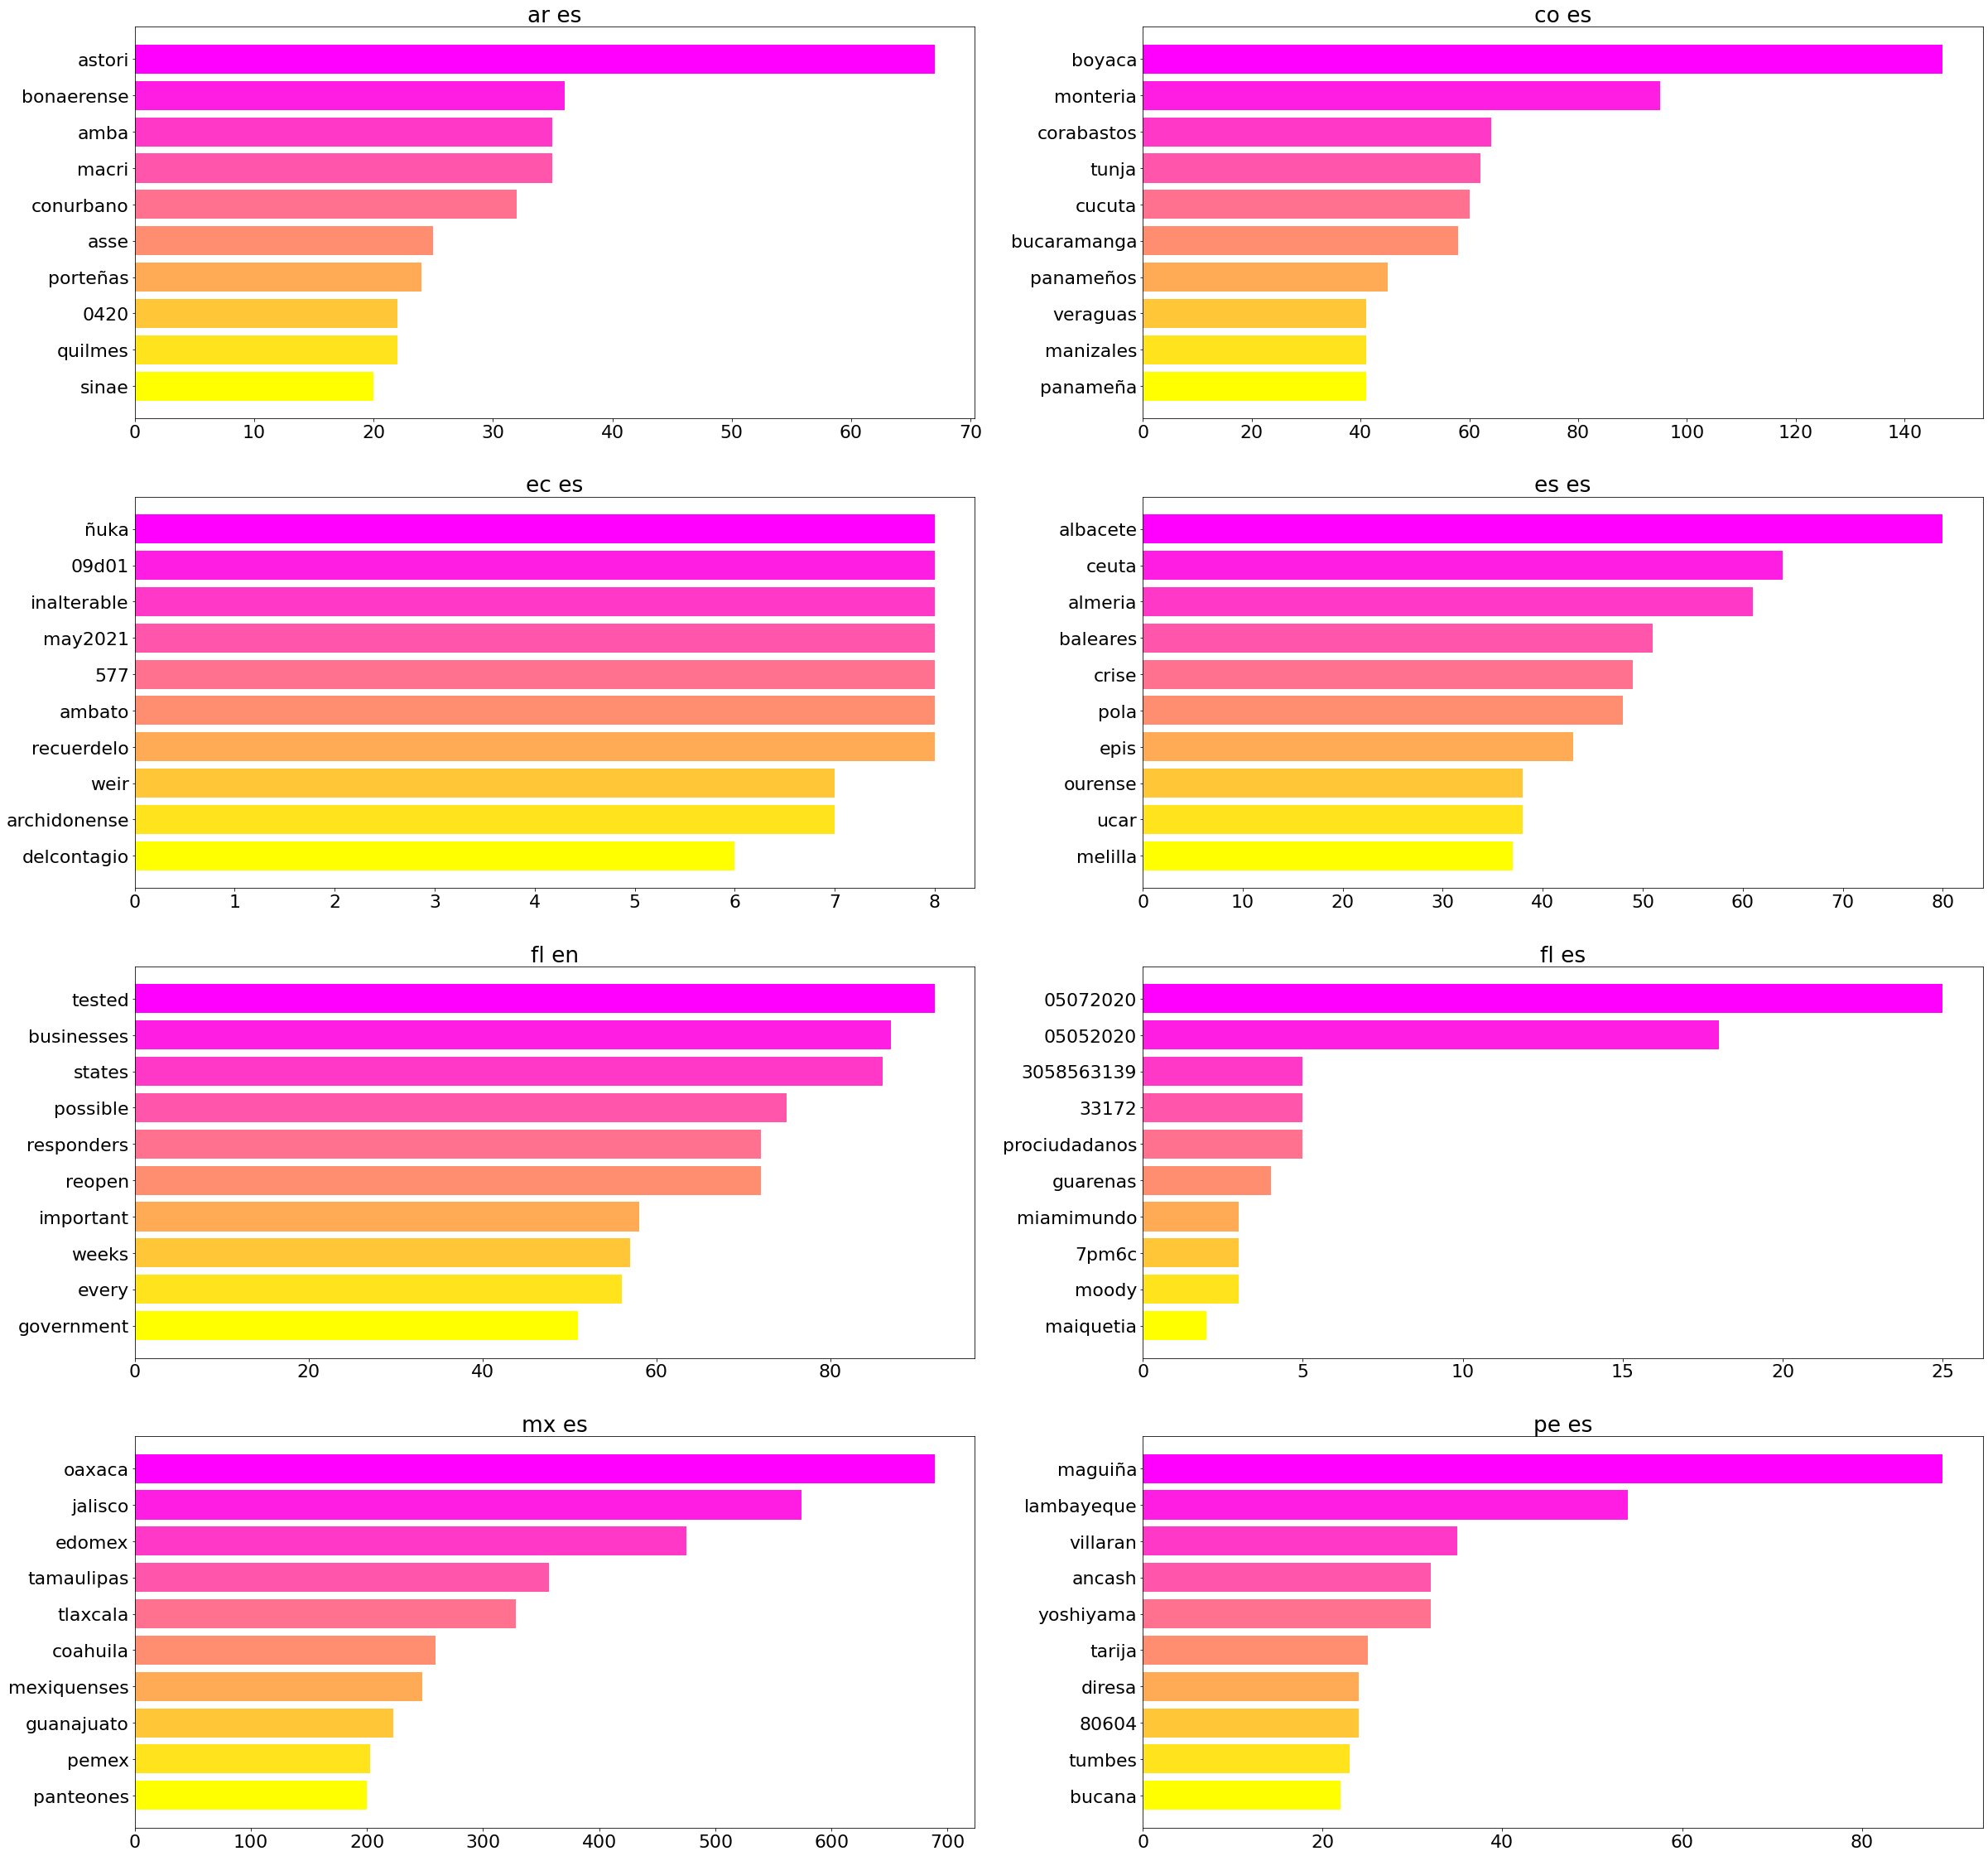

In [38]:
plot_bar_matrix(counts, num_cols = 2)

Note the words that are most frequent using this method and how it is (or isn't?) in conversation with the pandemic. Some surprising results can be observed: in `fl es`, the phone number `3058563139` is unique to Florida-Spanish and occurs frequently enough to make the top list. A quick search reveals this is the contact information for an immigration attorney. 

### 4.3 Unique words by date mode

Instead of obtaining words that are unique with respect to a location-language pair, we may be interested in retrieving words that are unique with respect to a given __date__. For instance, during the week of May 8, we may be interested in the words that occurred *only* on May 8, on May 9, and so on. This can help us understand trends. 

The work needed to accomplish this is analogous to Section 4.2. However, unlike the unique word mode for location-language pairs, this mode is best suited for studies on individual countries, e.g., the unique words by date in `fl-es`. Let's try this mode for `fl-es` during the week of May 8.

First, we need to prepare a query CSV with the contents of `fl-es` only. Remember that `coveet` is general and will work with whatever data is present in the CSV.  

In [43]:
!python3 coveet.py query -g fl -l es -d 2020-05-08 2020-05-14 -stopwords ../stopwords/stopwords_en.txt ../stopwords/stopwords_es.txt ../stopwords/stopwords_hashtags.txt

Namespace(date=[datetime.datetime(2020, 5, 8, 0, 0), datetime.datetime(2020, 5, 14, 0, 0)], func=<function handle_query at 0x11fc338c0>, geo=['fl'], lang=['es'], stopwords=['../stopwords/stopwords_en.txt', '../stopwords/stopwords_es.txt', '../stopwords/stopwords_hashtags.txt'])
wrote df to dhcovid_2020-5-8_to_2020-5-14_es_fl.csv!


We read in the query CSV into a pandas data frame and do the usual preprocessing work.

In [44]:
df = pd.read_csv('dhcovid_2020-5-8_to_2020-5-14_es_fl.csv')
df['date'] = pd.to_datetime(df['date'])
df['text'] = df['text'].str.split()
df['hashtags'] = df['hashtags'].str.split()

We prepare the unique vocabulary dictionary as we did earlier, and then obtain `counts`.

In [46]:
grouping = df.groupby([pd.Grouper(key='date', freq='D'), "geo", "lang"])["text"]  # D or W-MON
vocab_dic = uniq_vocab_by_group(grouping)  # unique vocab dictionary 
# recall that col_name is a toggle variable set earlier in the notebook ("text" or "hashtags")
df[col_name] = df.apply(lambda x : set(x[col_name]) & vocab_dic[(x['date'], x["geo"], x["lang"])],
                        result_type='reduce', axis=1)  # filtering tweets by that dic
# note to jerry: remember to un-tuple if the id pairs are date only

In [47]:
counts = {k: Counter(count_ngrams(t, n_gram, consecutive=False)).most_common(top_n) for k, t in grouping }

We print `counts` for inspection. Note how the key in this dictionary is not a `geo-lang` pair, but rather a `date-geo-lang` pair. 

In [48]:
pprint(counts)

{(Timestamp('2020-05-08 00:00:00', freq='D'), 'fl', 'es'): [(('madonna',), 5),
                                                            (('niño',), 4),
                                                            (('comprueba',), 4),
                                                            (('homenaje',), 3),
                                                            (('29',), 3),
                                                            (('381',), 3),
                                                            (('orlando',), 3),
                                                            (('sobrevivir',),
                                                             3),
                                                            (('odio',), 3),
                                                            (('agua',), 3)],
 (Timestamp('2020-05-09 00:00:00', freq='D'), 'fl', 'es'): [(('cama',), 3),
                                                            (('secuelas',), 3),
    

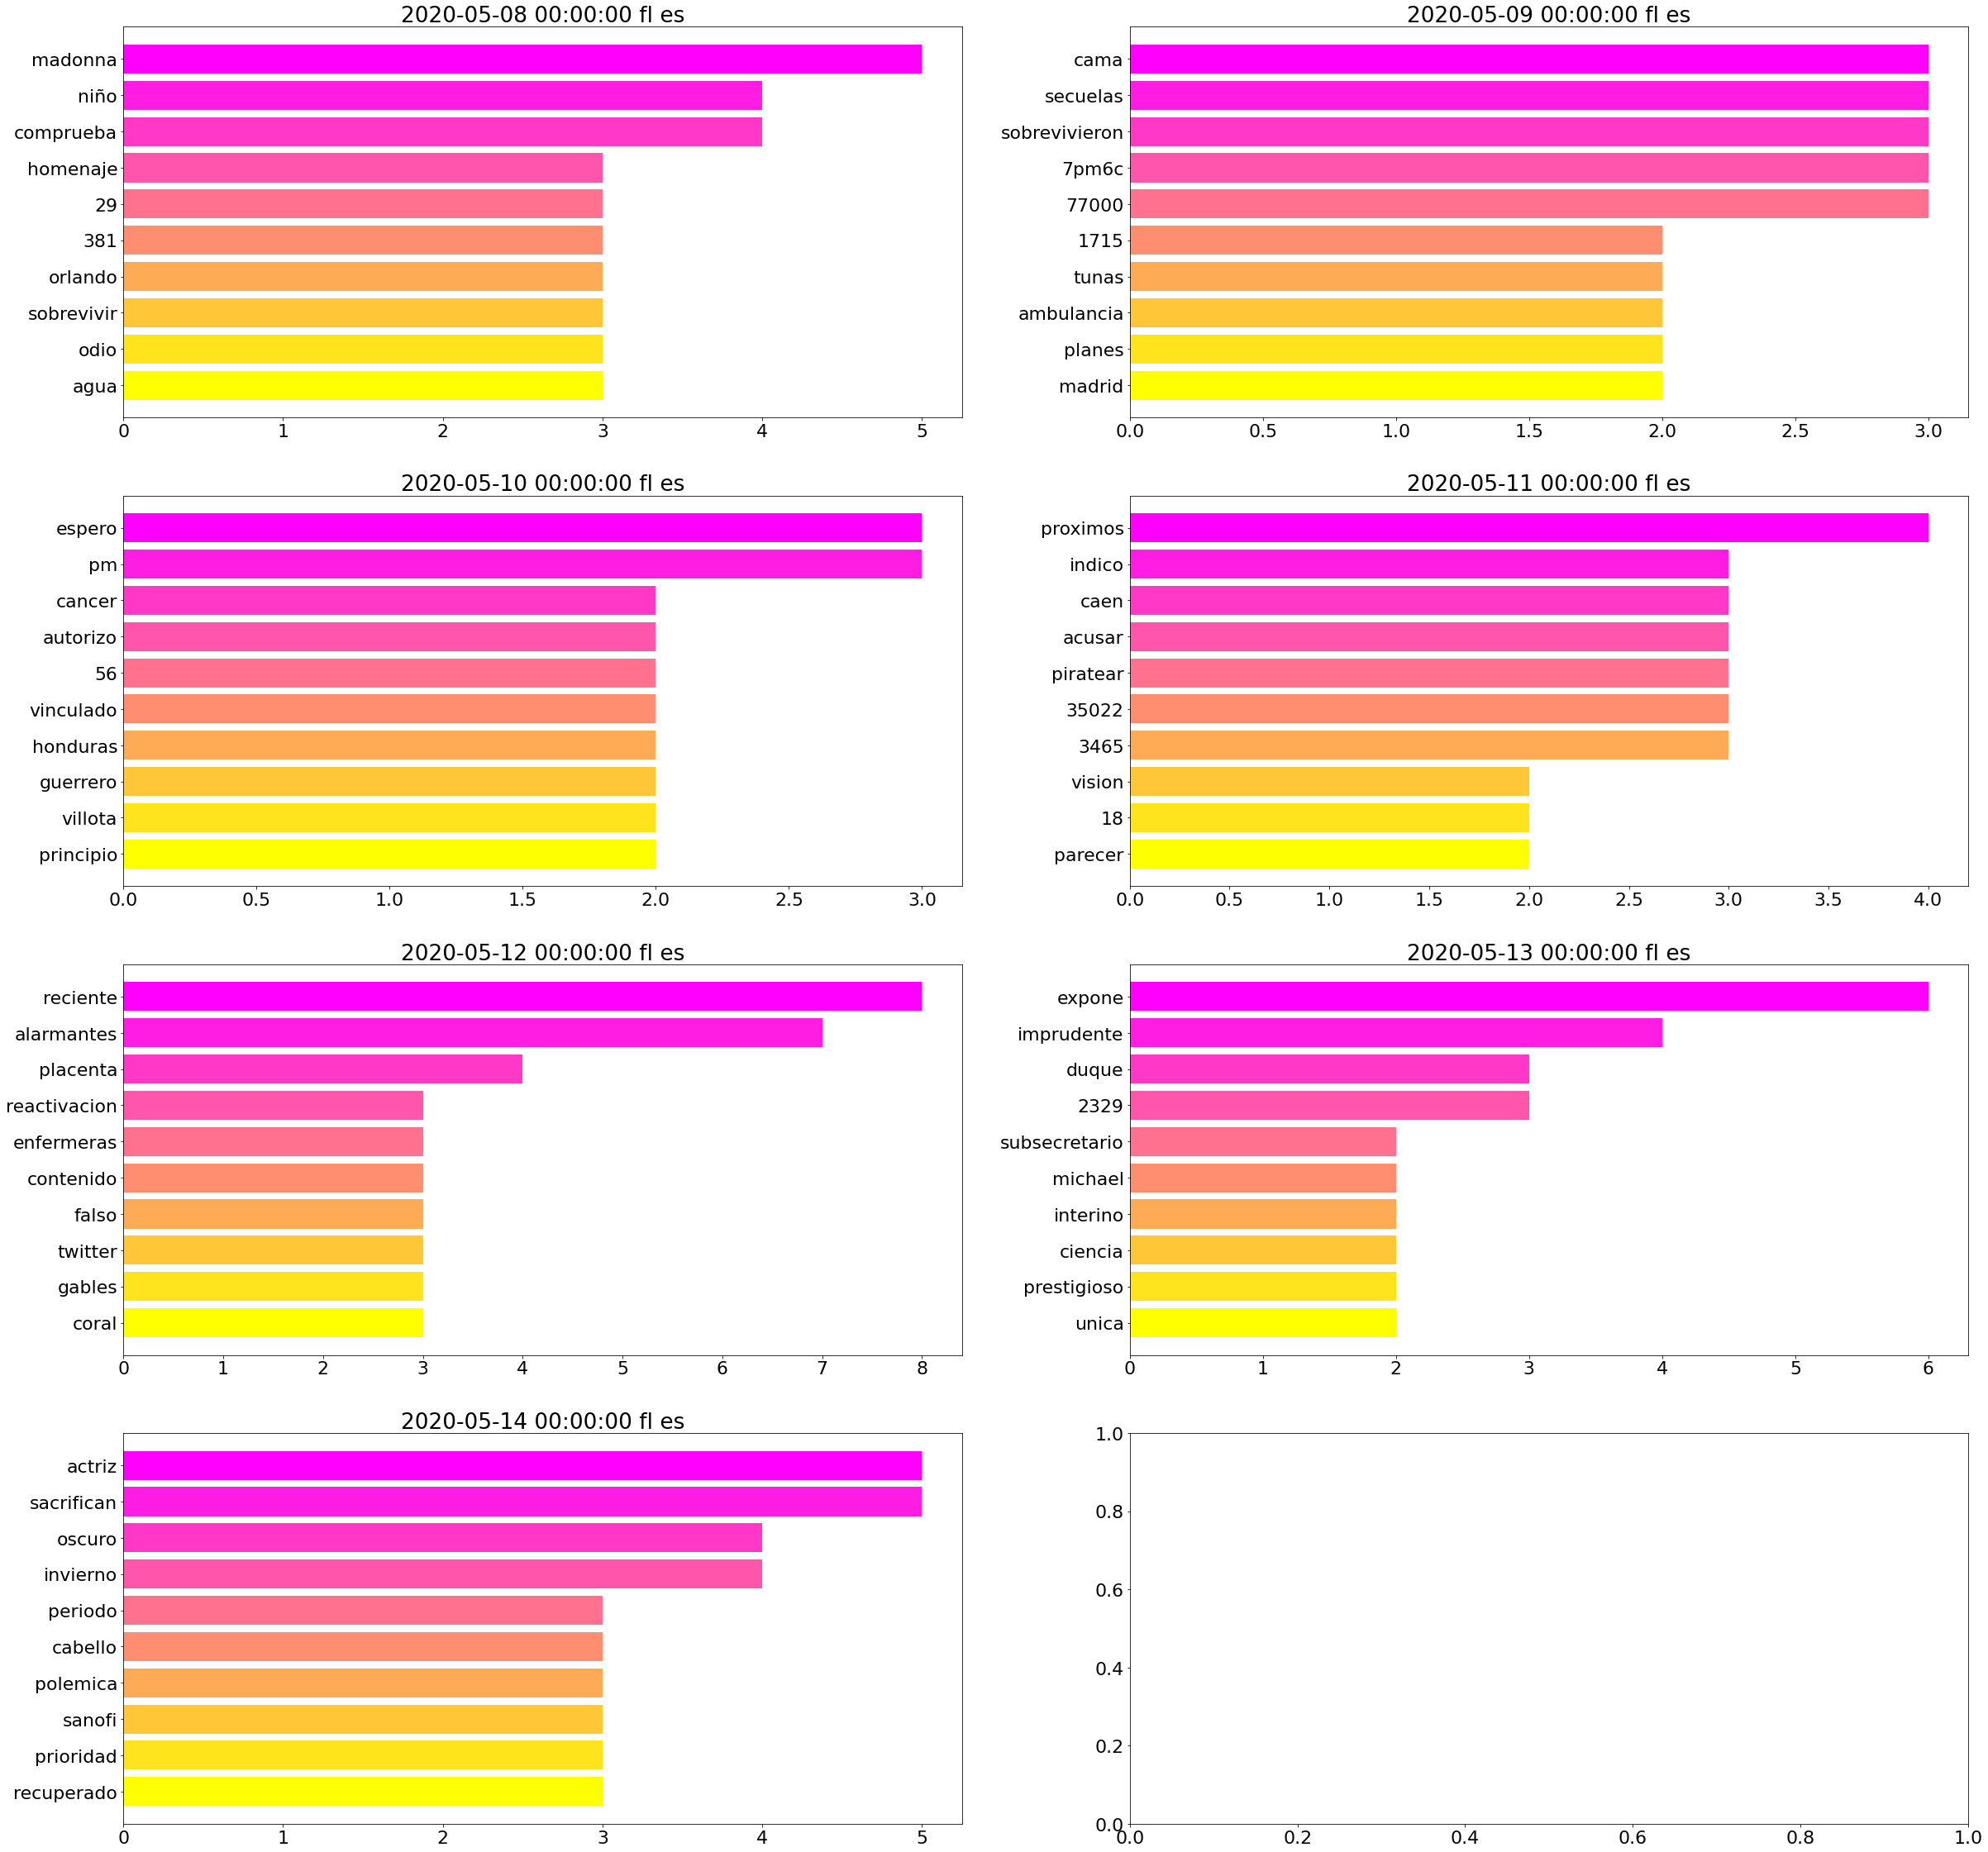

In [49]:
plot_bar_matrix(counts, num_cols = 2)

Note the very low frequency of words in this bar plot matrix, when compared to the unique words by location-language mode. That points to the idea that the vocabulary space of a location-language pair tends to be consistent from day to day. Some things to consider for experimentation:

* What happens when trying this mode in different weeks, e.g., the period immediately preceeding/following the spike of cases in Florida? Does the vocabulary space still remain consistent? 
* How about for location-language pairs other than `fl-es`?  
* Rather than day-by-day analysis, considering week-by-week or month-by-month analysis, i.e., the week becomes the unit of measure rather than the day.